# Установка пакетов

In [1]:
%%capture
!pip install evaluate

In [4]:
import datasets
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import pandas as pd
import torch
import numpy as np
import re

from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim

from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
import torch
from tqdm.notebook import tqdm
from datasets import Dataset
import evaluate
import shap
from transformers import pipeline


# Настройка для воспроизводимости
torch.manual_seed(42)
np.random.seed(42)

# Настройка matplotlib
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.style.use('seaborn-v0_8')



# Загрузка и подготовка данных
Загружаем датасет, преобразуем в pandas и маппим метки.

In [3]:
dataset = datasets.load_dataset("mxlcw/telegram-financial-sentiment-summarization", split='train')

dataset.shape

README.md:   0%|          | 0.00/175 [00:00<?, ?B/s]

telegram_data.csv:   0%|          | 0.00/27.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/18107 [00:00<?, ? examples/s]

(18107, 8)

In [6]:
data = dataset.to_pandas()
map_label = {'negative': 0, 'neutral': 1, 'positive' : 2}
data['label'] = data['regular_text_sentiment_label'].map(map_label)
data.head(), data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18107 entries, 0 to 18106
Data columns (total 9 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   date                             18107 non-null  object 
 1   post_url                         18107 non-null  object 
 2   text                             18107 non-null  object 
 3   summarized_text                  18107 non-null  object 
 4   regular_text_sentiment_label     18107 non-null  object 
 5   regular_text_sentiment_score     18107 non-null  float64
 6   summarized_text_sentiment_label  18107 non-null  object 
 7   summarized_text_sentiment_score  18107 non-null  float64
 8   label                            18107 non-null  int64  
dtypes: float64(2), int64(1), object(6)
memory usage: 1.2+ MB


(                  date                                           post_url  \
 0  2023-01-10 16:19:00  https://t.me/tinkoff_analytics_official/483/?e...   
 1  2023-01-11 15:04:00  https://t.me/tinkoff_analytics_official/484/?e...   
 2  2023-01-12 18:13:00  https://t.me/tinkoff_analytics_official/485/?e...   
 3  2023-01-16 17:16:00  https://t.me/tinkoff_analytics_official/486/?e...   
 4  2023-01-17 17:25:00  https://t.me/tinkoff_analytics_official/489/?e...   
 
                                                 text  \
 0  ​​Спрос на морские перевозки падает — как это ...   
 1  Новое бюджетное правило в действии  \nС 13 янв...   
 2  Ожидаемое замедление инфляции в США   \nВ дека...   
 3  Главными событиями прошлой недели стали возвра...   
 4  ​​Сбер: рост прибыли ускоряется  \nрекомендаци...   
 
                                      summarized_text  \
 0  Спрос на морские перевозки из Азии в США упал ...   
 1  Банк России возобновит операции с иностранной ...   
 2  Ожидаемое з

# Предварительный анализ данных
Анализируем распределение классов и статистику текста.

Категории: ['negative' 'neutral' 'positive']
Количество категорий: 3
Распределение по категориям:
regular_text_sentiment_label
positive    7876
neutral     7337
negative    2894
Name: count, dtype: int64


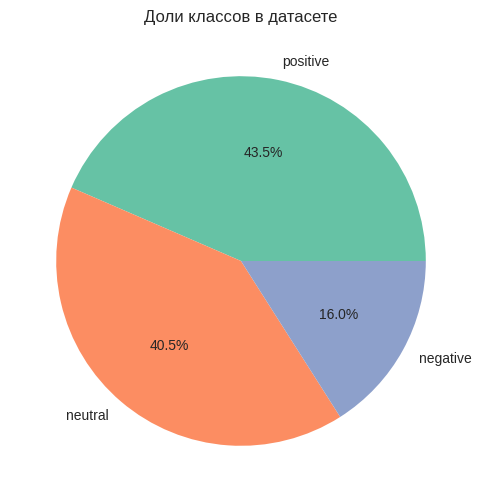

In [5]:
# Сколько и каких категорий есть в наборе
labels = data['regular_text_sentiment_label']
print('Категории:', labels.unique())
print('Количество категорий:', labels.nunique())
print('Распределение по категориям:')
print(labels.value_counts())

stats = labels.value_counts().reset_index()
stats.columns = ['Категория', 'Количество']
plt.figure(figsize=(6,6))
plt.pie(stats['Количество'], labels=stats['Категория'], autopct='%1.1f%%', colors=plt.cm.Set2.colors)
plt.title('Доли классов в датасете')
plt.show()

In [7]:
# Предварительный анализ текста

# Функции анализа
def analyze_text(text):
    words = re.split(r"\s+", text)  # Разделение на слова (простое, без лемматизации)
    unique_words = set(words)
    return len(words), len(unique_words)

def analyze_sentences(text):
    # Разделение на предложения с помощью регулярных выражений
    sentences = re.split(r'[.!?]+', text)  # Разделяем по . ! ?
    sentence_lengths = [len(re.split(r"\s+", sent)) for sent in sentences]  # Длина в словах
    return sentence_lengths

# Анализ всего датасета
total_words = []
total_unique = []
all_sentence_lengths = []

for text in data['text']:
    words_count, unique_count = analyze_text(text)
    total_words.append(words_count)
    total_unique.append(unique_count)
    
    sent_lengths = analyze_sentences(text)
    all_sentence_lengths.extend(sent_lengths)

# Средние значения
avg_words = np.mean(total_words)
avg_unique = np.mean(total_unique)
avg_sentence_length = np.mean(all_sentence_lengths) if all_sentence_lengths else 0

print(f"Среднее количество слов в сообщении: {avg_words:.2f}")
print(f"Среднее количество уникальных слов в сообщении: {avg_unique:.2f}")
print(f"Максимальное количество уникальных слов в сообщении: {np.max(total_words):.2f}")
print(f"Медианное количество уникальных слов в сообщении: {np.median(total_words):.2f}")
print(f"Средняя длина предложения в словах: {avg_sentence_length:.2f}")
print(f"Максимальная длина предложения: {max(all_sentence_lengths) if all_sentence_lengths else 0}")
print(f"95-й перцентиль длины предложения: {np.percentile(all_sentence_lengths, 95) if all_sentence_lengths else 0}")

Среднее количество слов в сообщении: 79.17
Среднее количество уникальных слов в сообщении: 63.23
Максимальное количество уникальных слов в сообщении: 634.00
Медианное количество уникальных слов в сообщении: 37.00
Средняя длина предложения в словах: 12.56
Максимальная длина предложения: 193
95-й перцентиль длины предложения: 31.0


# Подход 1: Embeddings + классификаторы
Получаем embeddings с помощью моделей, затем обучаем LR и RF с CV.

In [9]:
# Подход 1

tokenizers = {
    'deepvk/USER2-base' : AutoTokenizer.from_pretrained('deepvk/USER2-base'),
    'ai-sage/Giga-Embeddings-instruct' : AutoTokenizer.from_pretrained('ai-forever/ru-en-RoSBERTa')
}
models = {
    'deepvk/USER2-base' : AutoModel.from_pretrained('deepvk/USER2-base'),
    'ai-sage/Giga-Embeddings-instruct' : AutoModel.from_pretrained('ai-forever/ru-en-RoSBERTa')
}


# Функция для получения эмбеддингов с токенизацией
def get_embeddings(texts, model, model_name, batch_size=32):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    tokenizer = tokenizers[model_name]
    model = model.to(device)
    model.eval()
    
    embeddings = []
    for i in tqdm(range(0, len(texts), batch_size), desc=f"Получение эмбеддингов для {model_name}"):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts, return_tensors='pt', padding=True, truncation=True, max_length=200)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        with torch.no_grad():
            outputs = model(**inputs)
        # Среднее пула для эмбеддингов предложений
        emb = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
        embeddings.extend(emb)
    return embeddings

# Разделение данных (для финальной оценки, но CV использует весь датасет)
X = data['text']  
y = data['label']

# Функция для CV оценки с CI
def cv_accuracy_with_ci(model, X, y, cv=5):
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    scores = []
    for train_index, test_index in tqdm(skf.split(X, y), desc="CV folds", total=cv):
        # print(train_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        scores.append(acc)
    mean_acc = np.mean(scores)
    std_acc = np.std(scores)
    ci_lower = mean_acc - 1.96 * std_acc
    ci_upper = mean_acc + 1.96 * std_acc
    return mean_acc, (ci_lower, ci_upper)

# Сравнение моделей
results = {}
for model_name, models in models.items():
    print(f"Обработка модели: {model_name}")
    # Получите эмбеддинги для всего X (для CV)
    X_emb = get_embeddings(X.tolist(), models, model_name)
    X_emb = np.array(X_emb)
    
    # Логистическая регрессия с CV
    lr = LogisticRegression(max_iter=1000)
    lr_acc, lr_ci = cv_accuracy_with_ci(lr, X_emb, y)
    
    # Случайный лес с CV
    rf = RandomForestClassifier(random_state=42)
    rf_acc, rf_ci = cv_accuracy_with_ci(rf, X_emb, y)
    
    results[model_name] = {'LogisticRegression': lr_acc, 'LogisticRegression_CI': lr_ci, 'RandomForest': rf_acc, 'RandomForest_CI': rf_ci}
    print(f"{model_name} - LR: {lr_acc:.4f} (CI: {lr_ci[0]:.4f}-{lr_ci[1]:.4f}), RF: {rf_acc:.4f} (CI: {rf_ci[0]:.4f}-{rf_ci[1]:.4f})")

# Вывод результатов
print("Сравнение:")
for model, accs in results.items():
    print(f"{model}: LR={accs['LogisticRegression']:.4f} ({accs['LogisticRegression_CI'][0]:.4f}-{accs['LogisticRegression_CI'][1]:.4f}), RF={accs['RandomForest']:.4f} ({accs['RandomForest_CI'][0]:.4f}-{accs['RandomForest_CI'][1]:.4f})")

Some weights of RobertaModel were not initialized from the model checkpoint at ai-forever/ru-en-RoSBERTa and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Обработка модели: deepvk/USER2-base


Получение эмбеддингов для deepvk/USER2-base:   0%|          | 0/566 [00:00<?, ?it/s]

CV folds:   0%|          | 0/5 [00:00<?, ?it/s]

CV folds:   0%|          | 0/5 [00:00<?, ?it/s]

deepvk/USER2-base - LR: 0.7509 (CI: 0.7426-0.7592), RF: 0.6869 (CI: 0.6806-0.6931)
Обработка модели: ai-sage/Giga-Embeddings-instruct


Получение эмбеддингов для ai-sage/Giga-Embeddings-instruct:   0%|          | 0/566 [00:00<?, ?it/s]

CV folds:   0%|          | 0/5 [00:00<?, ?it/s]

lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

CV folds:   0%|          | 0/5 [00:00<?, ?it/s]

ai-sage/Giga-Embeddings-instruct - LR: 0.7708 (CI: 0.7541-0.7874), RF: 0.7291 (CI: 0.7205-0.7377)
Сравнение:
deepvk/USER2-base: LR=0.7509 (0.7426-0.7592), RF=0.6869 (0.6806-0.6931)
ai-sage/Giga-Embeddings-instruct: LR=0.7708 (0.7541-0.7874), RF=0.7291 (0.7205-0.7377)


# Подход 2: Fine-tuning моделей
Дообучаем transformers-модели с CV.

In [6]:
# подход 2
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import evaluate
from sklearn.model_selection import StratifiedKFold

# Выбор моделей
models = ['microsoft/Multilingual-MiniLM-L12-H384', 'seara/rubert-tiny2-russian-sentiment']

# Функция для CV с fine-tuning и progress bar
def cv_finetune_accuracy(model_name, data, cv=3):
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    scores = []
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    
    for fold, (train_index, test_index) in enumerate(tqdm(skf.split(data['text'], data['label']), desc=f"CV folds for {model_name}", total=cv)):
        # Разделение данных
        train_data = data.iloc[train_index]
        test_data = data.iloc[test_index]
        
        # Токенизация
        train_dataset = Dataset.from_pandas(train_data[['text', 'label']].rename(columns={'label': 'labels'}))
        test_dataset = Dataset.from_pandas(test_data[['text', 'label']].rename(columns={'label': 'labels'}))
        
        def tokenize_function(examples):
            return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=200)
        
        train_dataset = train_dataset.map(tokenize_function, batched=True)
        test_dataset = test_dataset.map(tokenize_function, batched=True)
        
        # Модель
        model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model.to(device)
        # Аргументы обучения
        training_args = TrainingArguments(
            output_dir=f'./results',
            eval_strategy='epoch',
            save_strategy='no',
            per_device_train_batch_size=8,
            per_device_eval_batch_size=8,
            num_train_epochs=2,
            logging_dir='./logs',
            report_to='none',
        )
        
        # Метрика
        metric = evaluate.load('accuracy')
        def compute_metrics(eval_pred):
            predictions, labels = eval_pred
            predictions = np.argmax(predictions, axis=1)
            return metric.compute(predictions=predictions, references=labels)
        # Тренер
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=test_dataset,
            compute_metrics=compute_metrics,
        )
        # Обучение и оценка
        trainer.train()
        eval_results = trainer.evaluate()
        scores.append(eval_results['eval_accuracy'])
    
    mean_acc = np.mean(scores)
    std_acc = np.std(scores)
    ci_lower = mean_acc - 1.96 * std_acc
    ci_upper = mean_acc + 1.96 * std_acc
    return mean_acc, (ci_lower, ci_upper)

# Сравнение моделей с CV
results_finetune = {}
for model_name in models:
    acc, ci = cv_finetune_accuracy(model_name, data)
    results_finetune[model_name] = {'accuracy': acc, 'CI': ci}
    print(f"{model_name} - Accuracy: {acc:.4f} (CI: {ci[0]:.4f}-{ci[1]:.4f})")

print("Сравнение дообученных моделей:")
for model, res in results_finetune.items():
    print(f"{model}: {res['accuracy']:.4f} ({res['CI'][0]:.4f}-{res['CI'][1]:.4f})")

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/430 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

CV folds for microsoft/Multilingual-MiniLM-L12-H384:   0%|          | 0/3 [00:00<?, ?it/s]

Map:   0%|          | 0/12071 [00:00<?, ? examples/s]

Map:   0%|          | 0/6036 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/471M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/Multilingual-MiniLM-L12-H384 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.898000,0.755776,0.689198
2,0.606200,0.602009,0.767064


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Map:   0%|          | 0/12071 [00:00<?, ? examples/s]

Map:   0%|          | 0/6036 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/Multilingual-MiniLM-L12-H384 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.900900,0.737261,0.704109
2,0.566800,0.548738,0.789264


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Map:   0%|          | 0/12072 [00:00<?, ? examples/s]

Map:   0%|          | 0/6035 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/Multilingual-MiniLM-L12-H384 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.830700,0.588357,0.756587
2,0.464500,0.468819,0.809445


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


microsoft/Multilingual-MiniLM-L12-H384 - Accuracy: 0.7886 (CI: 0.7547-0.8225)


tokenizer_config.json:   0%|          | 0.00/368 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

CV folds for seara/rubert-tiny2-russian-sentiment:   0%|          | 0/3 [00:00<?, ?it/s]

Map:   0%|          | 0/12071 [00:00<?, ? examples/s]

Map:   0%|          | 0/6036 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/911 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/117M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.583600,0.295269,0.876574
2,0.214100,0.283810,0.889662


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Map:   0%|          | 0/12071 [00:00<?, ? examples/s]

Map:   0%|          | 0/6036 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.578600,0.295149,0.880550
2,0.221600,0.266333,0.893970


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Map:   0%|          | 0/12072 [00:00<?, ? examples/s]

Map:   0%|          | 0/6035 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.590600,0.326308,0.863960
2,0.228600,0.278662,0.892461


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


seara/rubert-tiny2-russian-sentiment - Accuracy: 0.8920 (CI: 0.8885-0.8955)
Сравнение дообученных моделей:
microsoft/Multilingual-MiniLM-L12-H384: 0.7886 (0.7547-0.8225)
seara/rubert-tiny2-russian-sentiment: 0.8920 (0.8885-0.8955)


# Анализ ошибок и SHAP
Анализируем ошибки лучшей модели и объясняем предсказания с SHAP.

Лучшей моделью является seara/rubert-tiny2-russian-sentiment, это модель от ВШЭ.

Базовая база из confusion_matrix. А потом интересные SHAP

Map:   0%|          | 0/14485 [00:00<?, ? examples/s]

Map:   0%|          | 0/3622 [00:00<?, ? examples/s]

Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.593600,0.262838,0.889840
2,0.223000,0.278116,0.894809
3,0.120300,0.264448,0.907510


Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.


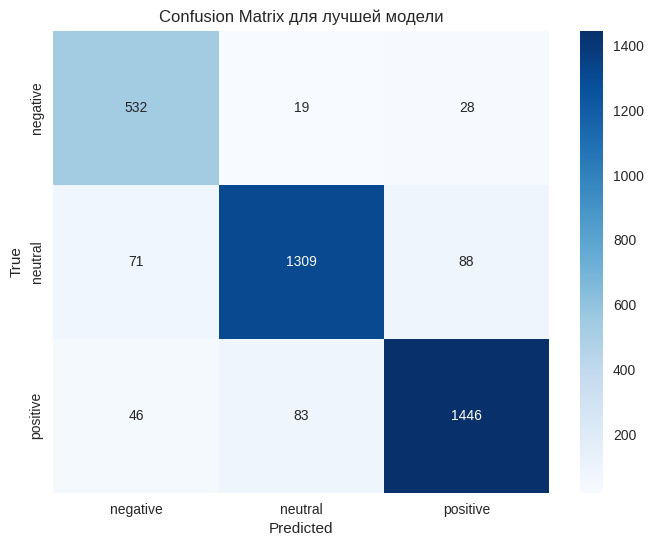

              precision    recall  f1-score   support

    negative       0.82      0.92      0.87       579
     neutral       0.93      0.89      0.91      1468
    positive       0.93      0.92      0.92      1575

    accuracy                           0.91      3622
   macro avg       0.89      0.91      0.90      3622
weighted avg       0.91      0.91      0.91      3622

Примеры ошибок (первые 5):
Текст: Прогнозы и комментарии. Снова понедельник ─ снова рост акций?  
  
Общий фон на российском рынке акц...
Истинный: neutral, Предсказанный: positive
---
Текст: #Макро  
 Уровень зернового производства на Украине не восстановится в 2023 году — ФАО

Истинный: neutral, Предсказанный: negative
---
Текст:  Российская нефть сейчас: 6600 руб. за бочку, дисконт сократился до $13. Цена возросла на +94% с нач...
Истинный: positive, Предсказанный: negative
---
Текст: ​​ Как инвестировать, когда валюта постоянно растет  
  
Курсы базовых валют за год прибавили от 50%...
Истинный: positive, Пр

In [20]:
best_model_name = 'seara/rubert-tiny2-russian-sentiment'

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42, stratify=data['label'])

tokenizer = AutoTokenizer.from_pretrained(best_model_name)
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=200)

train_dataset = Dataset.from_pandas(train_data[['text', 'label']].rename(columns={'label': 'labels'}))
test_dataset = Dataset.from_pandas(test_data[['text', 'label']].rename(columns={'label': 'labels'}))
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Модель
model = AutoModelForSequenceClassification.from_pretrained(best_model_name, num_labels=3, ignore_mismatched_sizes=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Аргументы обучения
training_args = TrainingArguments(
    output_dir='./results_best',
    eval_strategy='epoch',
    save_strategy='no',
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    logging_dir='./logs',
    report_to='none',
)

# Метрика
metric = evaluate.load('accuracy')
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

# Тренер
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

# Обучение
trainer.train()

# Предсказания на тесте
predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = test_data['label'].values

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.title('Confusion Matrix для лучшей модели')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=['negative', 'neutral', 'positive']))

# Примеры ошибок
errors = test_data[y_true != y_pred].copy()
errors['predicted'] = y_pred[y_true != y_pred]
errors['true_label'] = y_true[y_true != y_pred]
print("Примеры ошибок (первые 5):")
for idx, row in errors.head(5).iterrows():
    short_text = row['text'][:100] + "..." if len(row['text']) > 100 else row['text']
    print(f"Текст: {short_text}")
    print(f"Истинный: {row['regular_text_sentiment_label']}, Предсказанный: {['negative', 'neutral', 'positive'][row['predicted']]}")
    print("---")



In [24]:
sample_texts = errors['text'].head(5).tolist()

# SHAP с pipeline
pipe = pipeline("text-classification", model=model, tokenizer=tokenizer, device=device)

# SHAP Explainer
explainer = shap.Explainer(pipe)
shap_values = explainer(sample_texts)


print(f"Истинный класс: {['negative', 'neutral', 'positive'][errors['true_label'].iloc[0]]}")
shap.plots.text(shap_values[0])

Device set to use cuda
PartitionExplainer explainer: 6it [00:10, 10.84s/it]               

Истинный класс: neutral


In [22]:
print(f"Истинный класс: {['negative', 'neutral', 'positive'][errors['true_label'].iloc[2]]}")
shap.plots.text(shap_values[2])

Истинный класс: positive


# Тестирование на новых примерах

Проверка работы лучшей модели на новых сгенерированных примерах.

In [23]:
examples = [
    "ЦБ повысил ключевую ставку до 16%.",
    "Акции Газпрома выросли на фоне позитивных новостей.",
    "Рубль резко ослаб на торгах в понедельник.",
    "ВТБ объявил о рекордной прибыли за квартал.",
    "Инвесторы опасаются новых санкций против России."
]
example_labels = ["neutral", "positive", "negative", "positive", "negative"]

new_labels_numeric = [map_label[label] for label in example_labels]

# Predict on new data
def predict_new(texts):
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=200)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    preds = np.argmax(outputs.logits.cpu().numpy(), axis=1)
    return preds

predictions = predict_new(examples)
print("Predictions on new data:")
for i, (text, true, pred) in enumerate(zip(examples, new_labels_numeric, predictions)):
    print(f"Text {i+1}: {text}")
    print(f"True: {true} ({['negative', 'neutral', 'positive'][true]}), Predicted: {pred} ({['negative', 'neutral', 'positive'][pred]})")
    print("---")

# Accuracy on new data
acc = accuracy_score(new_labels_numeric, predictions)
print(f"Accuracy on new examples: {acc:.4f}")

Predictions on new data:
Text 1: ЦБ повысил ключевую ставку до 16%.
True: 1 (neutral), Predicted: 2 (positive)
---
Text 2: Акции Газпрома выросли на фоне позитивных новостей.
True: 2 (positive), Predicted: 2 (positive)
---
Text 3: Рубль резко ослаб на торгах в понедельник.
True: 0 (negative), Predicted: 0 (negative)
---
Text 4: ВТБ объявил о рекордной прибыли за квартал.
True: 2 (positive), Predicted: 2 (positive)
---
Text 5: Инвесторы опасаются новых санкций против России.
True: 0 (negative), Predicted: 0 (negative)
---
Accuracy on new examples: 0.8000


Ого ошибка только в одном.

Моделька ВШЭ хороша однако